In [1]:
# scipy.io.savemat('data/1/data.mat',dict([('ks_data_origin',ks_data_origin),
#                 ('b.output_w',b.output_w),('rmse',rmse),('rmse_vec',rmse_vec),
#                 ('rmse_vert',rmse_vert),('pred_output',pred_output),('xx_',xx_),
#                 ('tt',tt)]))

In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import scipy.io

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data1D
import data_utils

%load_ext autoreload
%autoreload 2
%aimport data1D
%aimport reservoir


%matplotlib inline
import matplotlib.pyplot as plt

# setx PATH "%PATH%;C:\Octave\Octave-5.1.0.0

In [2]:
# Input data
n_sequence=1
spatial_points = 65
lyap_exp = 0.0461
n_train = 4000
n_test = 3000
forget = 500
parallel_runs = 1
ks_data_origin, xx_, tt = data1D.kuramoto_sivashinsky_from_dataset(sequence_length=n_train+n_test, n_sequence=n_sequence)
# ks_data_origin=ks_data_origin+np.random.rand(ks_data_origin.shape[0],ks_data_origin.shape[1],ks_data_origin.shape[2])
ks_data_train = data_utils.scale(ks_data_origin[:, :n_train, :], [0, 1])
input_shape=ks_data_train.shape

In [3]:
# b.activation_param0 = None
b = Reservoir(n_res=2000, res_scale=0.33, res_encoding='phase',
              input_enc_param=np.pi, res_enc_param=np.pi,
              input_scale=0.874, input_encoding='phase',
#               scale_input_MinMax = (0, 1), scale_res_MinMax = None, scale_output_MinMax = (0, 1), # data standardization
              raw_input_feature = True, enc_input_feature = False, # concatenated states properties
              random_projection='simulation', weights_type='complex gaussian',
              activation_fun='intensity_in_tanh', activation_param=None,
              parallel_runs=parallel_runs, bias_scale=0, leak_rate=0,
              pred_horizon=1, rec_pred_steps=460, forget = forget,
              train_method='ridge', train_param=0.25, verbose=1
             )

# Algorithm training
b.fit(ks_data_train);

Reservoir Computing algorithm - Training phase:

Initialization complete. 		Elapsed time: 0.36943697929382324 s



Reservoir iterations complete. 		Elapsed time: 20.142477989196777 s
Training complete. 			Elapsed time: 1.3640193939208984 s
Training score: 0.9999332745413767


In [4]:
np.std(np.std(b.c[0, :, :-65].T, axis=0))

0.0033192351959532877

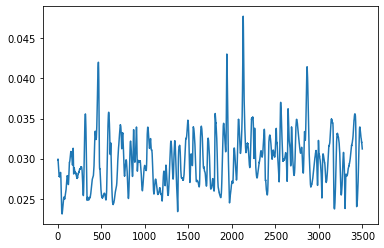

In [5]:
plt.plot(np.std(b.c[0, :, :-65].T, axis=0))

In [6]:
print(b.activation_param)
print(b.activation_param0)

6.616878010473488
2.4485691530354807


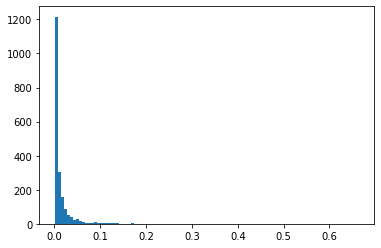

In [7]:
plt.hist((b.xx).T, bins=100);

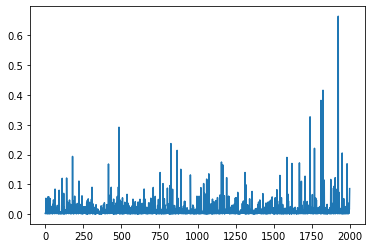

In [8]:
plt.plot(b.xx.T)

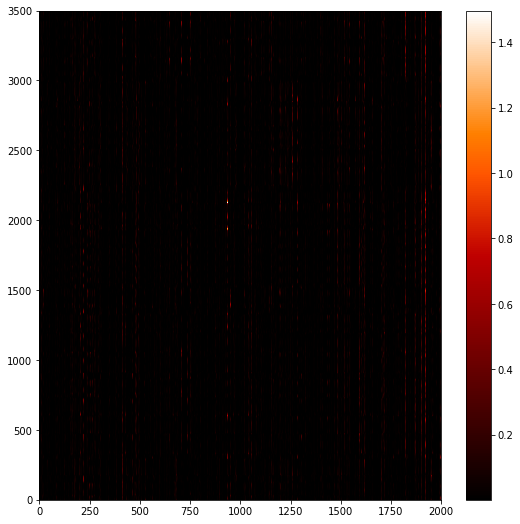

In [9]:
plt.figure(1,figsize=(9,9))
im=plt.pcolormesh(b.c[0,:,:-65], cmap='gist_heat')
plt.colorbar(im)

In [10]:
# testing data
ks_data_test = data_utils.scale(ks_data_origin[:, n_train:, :], [0, 1])

# Algorithm testing
b.parallel_test_runs=200
pred_output, rmse, rmse_vec, rmse_vert = b.predict_and_score(ks_data_test, detailed_score=True)

Reservoir Computing algorithm - Testing phase:

Initialization complete. 		Elapsed time: 0.00024271011352539062 s



Reservoir iterations complete. 		Elapsed time: 84.85416960716248 s
Testing complete. 			Elapsed time: 6.614718437194824 s
Testing score: 0.5034707264092135


best plot is at 25


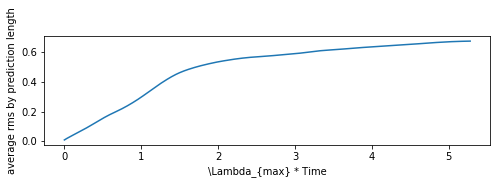

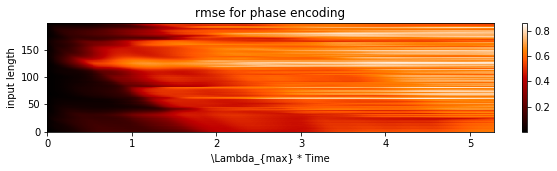

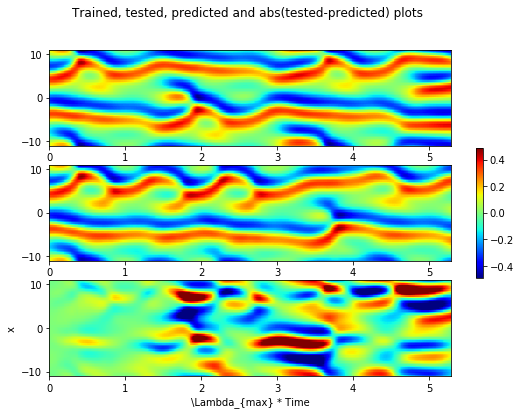

In [11]:
total_pred = (rmse.shape[1])
length_input = pred_output.shape[0] - total_pred
time_input = range(rmse.shape[0])
time_pred = tt[0:total_pred]*lyap_exp

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by prediction length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(time_pred[:], rmse_vec[:])
# scipy.io.savemat('time_pred_new_2.mat', dict(time_pred_new_2=time_pred))
# scipy.io.savemat('rmse_vec_new_2.mat', dict(rmse_vec_new_2=rmse_vec))
plt.show;
# plt.savefig('phase_LM_kuramoto_rmse.png', dpi=400)

plt.figure(2,figsize=(10,2))
plt.title('rmse for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(time_pred[:], time_input[:], rmse[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

xx = xx_
############################################################################
n_input = np.argmin(np.sum(rmse[:,:200], axis=1)) # np.argmin(rmse_vert)
# n_input = 198
#############################################################################
total_pred = b.pred_horizon*b.rec_pred_steps

input_data = ks_data_test[0, b.forget:b.forget+total_pred, :]-0.5
targetted_data = ks_data_test[0, n_input+b.forget:n_input+b.forget+total_pred, :]-0.5

prediction = pred_output[n_input, :].reshape(targetted_data.shape)-0.5

vmax = max(abs(np.concatenate((targetted_data, input_data)).flatten()))
vmin = -vmax

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,6))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')

datum = [targetted_data, prediction, targetted_data-prediction]
xx_axs = np.zeros((spatial_points, total_pred))
time_axs = np.zeros((spatial_points, total_pred))
for i in range(total_pred):
    xx_axs[:, i] = xx
for i in range(spatial_points):
    time_axs[i, :] = (tt[n_input+b.forget:n_input+b.forget+total_pred]-tt[n_input+b.forget])*lyap_exp
for i in range(3):
    im=axs[i].pcolormesh(time_axs, xx_axs, datum[i].T, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)
# plt.savefig('phase_SLM_kuramoto_pred.png', dpi=400)

print('best plot is at '+str(np.argmin(rmse_vert)))

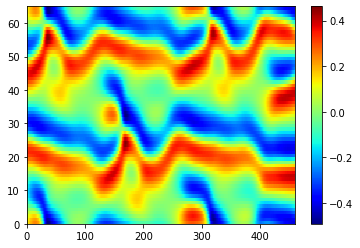

In [12]:
im=plt.pcolormesh(datum[0].T, cmap=plt.get_cmap('jet'))
plt.colorbar(im)

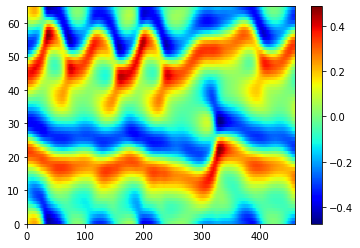

In [13]:
im=plt.pcolormesh(datum[1].T, cmap=plt.get_cmap('jet'))
plt.colorbar(im)

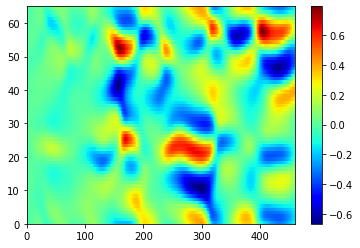

In [14]:
im=plt.pcolormesh(datum[2].T, cmap=plt.get_cmap('jet'))
plt.colorbar(im)

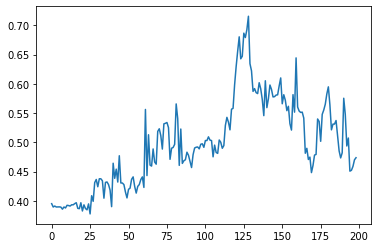

In [15]:
plt.plot(rmse_vert[:])